In [1]:
!pip install tf-agents
!pip install tensorflow

     |████████████████████████████████| 1.3 MB 36.9 MB/s 


In [2]:
import abc
import copy
import math
import random
import numpy as np
import gym
from gym import spaces

import tensorflow as tf
from tf_agents.agents.dqn.dqn_agent import DqnAgent, DdqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import utils
from tf_agents.trajectories import trajectory
from tf_agents.environments import wrappers
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.utils import common
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

import matplotlib
import matplotlib.pyplot as plt
from skimage.draw import line

from google.colab.patches import cv2_imshow

tf.compat.v1.enable_v2_behavior()

IMG_DIM = 512
NUMBER_ITERATION = 30000
COLLECTION_STEPS_PER_ITERATION = 1
REPLAY_BUFFER_MAX_LENGTH = 100000
BATCH_SIZE = 128
EVAL_EPISODES = 20
EVAL_INTERVAL = 1000
INITIAL_COLLECT_STEPS = 1000
LEARNING_RATE = 3e-4

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  pass
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


In [4]:
#Given 3 points, check their orientation -> 0 = colinear, 1 = clockwise, -1 = counter-clockwise
def get_orientation(A, B, C):

  val = ((B[1] - A[1]) * (C[0] - B[0])) - ((B[0] - A[0]) * (C[1] - B[1]))
  if val == 0 : return 0
  return 1 if val > 0 else -1

#Check if segments intersect
def is_segm_intersection(S1, S2):

  (A1, B1) = S1
  (A2, B2) = S2

  if A1 == A2 or A1 == B2 or B1 == A2 or B1 == B2:
    return False

  #find all orientations
  o1 = get_orientation(A1, B1, A2)
  o2 = get_orientation(A1, B1, B2)
  o3 = get_orientation(A2, B2, A1)
  o4 = get_orientation(A2, B2, B1)

  #general case
  if o1 != o2 and o3 != o4:
    return True

  return False

def intersects_any(S, segments):

  for s in segments[:-1]:
    if is_segm_intersection(S, s) == True:
      return True

  return False

#check if a pixel is outside of image
def is_out_of_bounds(A, n):
  (x, y) = A
  return x < 0 or y < 0 or x >= n or y >= n 

#check if a pixel is on the edge of the image
def is_marginal_node(A, n):
  (x, y) = A
  return x == 0 or y == 0 or x == (n - 1) or y == (n - 1)

In [5]:
#given a point, get the equivalent point at a given distance and given angle
def apply_translation_to(position, angle, distance):
  x = distance * math.cos(math.radians(angle))
  y = distance * math.sin(math.radians(angle))
  return (position[0] + x, position[1] + y)

#rotate a position to left with a number of degrees
def rotate_left(position, degree_angle):
  (x, y) = position
  adjustedX = (x * math.cos(math.radians(degree_angle))) - (y * math.sin(math.radians(degree_angle)))
  adjustedY = (y * math.cos(math.radians(degree_angle))) + (x * math.sin(math.radians(degree_angle)))
  return (round(adjustedX), round(adjustedY))

#given a position, get the point at a certaing angle and distance
def get_position_of(last_position, angle, distance, angle_adjustment=0):
  rotated_left_position = rotate_left(last_position, 360 - angle_adjustment)
  translated_location = apply_translation_to(rotated_left_position, angle, distance)
  return rotate_left(translated_location, angle_adjustment)

In [6]:
MAX_STEPS = 40

ACTION_DIST = 0
ACTION_ANGLE = 1
ACTION_INTER = 2
ACTION_END = 3

MAX_ACTIONS = 44

FIXED_DIST = 40
FIXED_HISTORY = 20

def convert_integer_to_action(code):

    '''
    0...20 -> bins of 10 values: 0 = [0..9], 1 = [10..19]..etc
    21...38 -> bins of 10 values: 21 = [0..9], 22 = [10..19]..etc
    39...43 -> 39 == INTER_3, 40 == INTER_4, 41 == INTER_5, 42 == INTER_6, 43 == INTER_7
    44 -> END
    '''

    action, value = (-1, -1)

    if code <= 20:
        action = ACTION_DIST
        value = FIXED_DIST
        #value = (code - 0) * 10 + random.randint(0, 9)

    elif code <= 38:
        action = ACTION_ANGLE
        value = ((code - 21) * 10 + random.randint(0, 9)) - 90

    elif code <= 43:
        action = ACTION_INTER
        value = code - 39 + 3

    elif code == 44:
        action = ACTION_END
        value = code

    #print(code, ' -> ', (action, value))

    return (action, value)

class RoadNetworkEnv(py_environment.PyEnvironment):

    def __init__(self):

        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=MAX_ACTIONS, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(FIXED_HISTORY + 1,), dtype=np.float64, minimum=np.full((FIXED_HISTORY + 1,), -1, dtype=np.float64),maximum=np.full((FIXED_HISTORY + 1,), 5, dtype=np.float64), name='observation')
        self._state=[0]
        self._action_timeline = np.zeros(4,)
        self._episode_ended = False
        self._reward = 0
        self._timestamp = 0
        self._action_history = np.full((FIXED_HISTORY,), -1, dtype=np.int32)
        self._image = np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)

        self._edges = []
        self._nodes = [(0, 255)]
        self._nodes_to_expand = [(ACTION_ANGLE, (0, 255), 0, 0)]
        self._action_history[-1] = ACTION_ANGLE
        self._state = np.concatenate((self._state, self._action_history))

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def update_state(self):
        self._state = [0]
        (_, (xA, yA), angle, _) = self._nodes_to_expand[-1]
        (xB, yB) = get_position_of((xA, yA), 0, FIXED_DIST, angle)
        rr, cc = line(xA, yA, xB, yB)
        for i in range(len(rr)):
          r = rr[i]
          c = cc[i]
          if is_out_of_bounds((r, c), IMG_DIM) or self._image[r, c] != 0:
            self._state = [1]
        
        self._state = np.concatenate((self._state, self._action_history))


    def apply_action(self, action):

        self._timestamp += 1

        (action_type, action_value) = convert_integer_to_action(action)
        (last_action, position, angle, steps) = self._nodes_to_expand.pop(0)
        
        time_diff = self._timestamp - self._action_timeline[action_type]
        self._action_history = np.roll(self._action_history, -1)
        self._action_history[-1] = action_type

        is_oob = False
        is_marginal = False
        is_self_inter = False

        if action_type == ACTION_DIST:
          new_position = get_position_of(position, 0, action_value, angle)

          is_oob = is_out_of_bounds(new_position, IMG_DIM)
          is_marginal = is_marginal_node(new_position, IMG_DIM)
          is_self_inter = intersects_any((position, new_position), self._edges)

        if last_action == ACTION_DIST:
            if action_type == ACTION_ANGLE:
              self._reward = 0 if time_diff - 1 < 0 else 10
            elif action_type == ACTION_INTER:
              self._reward = 0 if time_diff - 15 < 0 else 13 - action_value
            elif action_type == ACTION_END:
              self._reward = 0 if time_diff - 18 < 0 else 5
            else:
              self._reward = 10

        elif last_action == ACTION_ANGLE:
            if action_type == ACTION_DIST:
              self._reward = 15
            else:
              self._reward = 0

        elif last_action == ACTION_INTER:
            if action_type == ACTION_DIST:
              self._reward = 20
            else:
              self._reward = 0


        if is_oob == True or is_self_inter == True:
            #if is_oob == True:
            #  print("Position out of bounds")
            #else:
            #  print("Self intersection")
            #print("Current position: ", position)
            #print("Next position: ", new_position)
            #print("+++++++++++++++++++++++++++++++++++++++")
            self._reward = -1000
            self._episode_ended = True
            return


        if action_type == ACTION_DIST:
            self._nodes_to_expand.append((ACTION_DIST, new_position, angle, steps + 1))
            if position != new_position and (len(self._edges) == 0 or (position, new_position) != self._edges[-1]):
              self._edges.append((position, new_position))
              self._nodes.append(new_position)
              self.draw_edge(position, new_position)

        elif action_type == ACTION_ANGLE:
            self._nodes_to_expand.append((ACTION_ANGLE, position, (angle + action_value), steps + 1))

        elif action_type == ACTION_INTER:
            if last_action != ACTION_INTER:
              MIN_INTER_ANGLE = 45
              prev_angle = -180
              angle_sum = 0
              for i in range(action_value - 1):
                  remaining = (360 - angle_sum - ((action_value - i) * MIN_INTER_ANGLE))
                  gen_angle = random.randint(MIN_INTER_ANGLE, remaining)
                  forced_angle = prev_angle + gen_angle
                  angle_sum += gen_angle
                  prev_angle = forced_angle
                  self._nodes_to_expand.append((ACTION_INTER, position, (angle + forced_angle), steps + 1))
            else:
                self._nodes_to_expand.insert(0, (last_action, position, angle, steps))

        if is_marginal == True:
            self._reward += 1

        nr_dist = (self._action_history == ACTION_DIST).sum()
        nr_angles = (self._action_history == ACTION_ANGLE).sum()
        nr_inter = (self._action_history == ACTION_INTER).sum()
        nr_ends = (self._action_history == ACTION_END).sum()
        nr_none = (self._action_history == -1).sum()

        if action_type == ACTION_DIST and nr_dist > 18:
            self._reward = -500

        if action_type == ACTION_ANGLE and nr_angles > 16:
            self._reward = -500

        if action_type == ACTION_INTER and (nr_inter + nr_none) > 4:
            self._reward = -500

        if action_type == ACTION_END and (nr_ends + nr_none) > 2:
            self._reward = -500

        if len(self._nodes_to_expand) == 0:
            self._reward = 1000 if len(self._edges) > 10 else 0
            self._episode_ended = True
            return
       

        self._action_timeline[action_type] = self._timestamp
        self.update_state()
  
    def _reset(self):

        #print("RESET WAS CALLED pre!!!! -> ", self._nodes_to_expand)

        self._state=[0]
        self._episode_ended = False
        self._reward = 0
        self._edges = []
        self._nodes = [(0, 255)]
        self._nodes_to_expand = [(ACTION_ANGLE, (0, 255), 0, 0)]
        self._timestamp = 0
        self._action_timeline = np.zeros(4,)
        self._action_history = np.full((FIXED_HISTORY,), -1, dtype=np.int32)
        self._action_history[-1] = ACTION_ANGLE
        self._state = np.concatenate((self._state, self._action_history))
        self._image = np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)

        return ts.restart(np.array(self._state, dtype=np.float64))


    def _step(self, action):

        if self._episode_ended == True:
            return self.reset()

        self.apply_action(action)
            
        if self._episode_ended == True:
          return ts.termination(np.array(self._state, dtype=np.float64), self._reward)
        else:
          return ts.transition(np.array(self._state, dtype=np.float64), reward=self._reward, discount=0.9)

    def draw_edge(self, position, new_position):
        (xA, yA) = position
        (xB, yB) = new_position   
        rr, cc = line(xA, yA, xB, yB)
        self._image[rr, cc] = 255

    def render(self, mode='human'):
        print(self._edges)
        print(self._state)
        return self._image

In [7]:
env = RoadNetworkEnv()
utils.validate_py_environment(env)

tl_env = wrappers.TimeLimit(env, duration=5000)

time_step = tl_env.reset()
rewards = time_step.reward

for i in range(100):
    action = np.random.choice(range(MAX_ACTIONS))
    time_step = tl_env.step(action)
    rewards += time_step.reward

In [8]:
train_py_env = wrappers.TimeLimit(RoadNetworkEnv(), duration=1000)
eval_py_env = wrappers.TimeLimit(RoadNetworkEnv(), duration=1000)

print('Observation Spec:')
print(train_py_env.time_step_spec().observation)

print('Reward Spec:')
print(train_py_env.time_step_spec().reward)

print('Action Spec:')
print(train_py_env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
evaluation_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Observation Spec:
BoundedArraySpec(shape=(21,), dtype=dtype('float64'), name='observation', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.], maximum=[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=44)


In [9]:
hidden_layers = (264, 512, 1024,)

q_network = QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=hidden_layers)

counter = tf.Variable(0)

agent = DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_network,
    debug_summaries = True,
    epsilon_greedy = 0.30,
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = counter)

agent.initialize()
agent.collect_policy

In [10]:
#This method is used for calculations of how much reward has agent gained on average.
def get_average_return(environment, policy, episodes=20):

  total_return = 0.0

  for _ in range(episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

    total_return += episode_return
  
  avg_return = total_return / episodes
  return avg_return.numpy()[0]

In [11]:
class ExperienceReplay(object):
    def __init__(self, agent, enviroment):

        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=enviroment.batch_size,
            max_length=REPLAY_BUFFER_MAX_LENGTH)
        
        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())
        
        self.collect_data(train_env, self._random_policy, steps=INITIAL_COLLECT_STEPS)
        
        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=BATCH_SIZE, 
            num_steps=2).prefetch(3)

        self.iterator = iter(self.dataset)
    
    def collect_data(self, enviroment, policy, steps):
        for _ in range(steps):
            self.collect_step(enviroment, policy)
            
    def collect_step(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)
        self._replay_buffer.add_batch(timestamp_trajectory)

experience_replay = ExperienceReplay(agent, train_env)

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [12]:
agent.train = common.function(agent.train)

#initialize counter on the agent to 0
agent.train_step_counter.assign(0)


with tf.device('/device:GPU:0'):
  #get initial average return of reward
  #avg_return = get_average_return(evaluation_env, agent.policy, EVAL_EPISODES)
  #returns = [avg_return]
  
  layers_values = agent._q_network.layers[0].get_weights()[0]
  for _ in range(NUMBER_ITERATION):
      
      experience_replay.collect_data(train_env, agent.collect_policy, COLLECTION_STEPS_PER_ITERATION)
      
      experience, unused_info  = next(experience_replay.iterator)
      train_loss = agent.train(experience).loss

      new_values = agent._q_network.layers[0].get_weights()[0]

      #print("Layers update were not changed: ", np.all(layers_values == new_values))
      layers_values = new_values

      if agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
           #avg_return = get_average_return(evaluation_env, agent.policy, EVAL_EPISODES)
           print('Iteration {0} – Average Return = {1}, Loss = {2}.'.format(agent.train_step_counter.numpy(), 0, train_loss))
           #returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Iteration 1000 – Average Return = 0, Loss = 115702.8828125.
Iteration 2000 – Average Return = 0, Loss = 58155.171875.
Iteration 3000 – Average Return = 0, Loss = 44719.1484375.
Iteration 4000 – Average Return = 0, Loss = 88762.2109375.
Iteration 5000 – Average Return = 0, Loss = 41167.1484375.
Iteration 6000 – Average Return = 0, Loss = 43977.6875.
Iteration 7000 – Average Return = 0, Loss = 20546.9375.
Iteration 8000 – Average Return = 0, Loss = 47082.3046875.
Iteration 9000 – Average Return = 0, Loss = 62805.625.
Iteration 10000 – Average Return = 0, Loss = 43495.95703125.
Iteration 11000 – Average Return = 0, Loss = 87429.46875.
Iteration 12000 – Average Return = 0, Loss = 89177.859375.
Iteration 13000 – Average Return = 0, Loss = 38787.04296875.
Iterat

In [13]:
def create_policy_eval(policy, num_episodes=5):
  for _ in range(num_episodes):
    time_step = evaluation_env.reset()
    #cv2_imshow(eval_py_env.render())
    while not time_step.is_last():
      action_step = policy.action(time_step)
      print(action_step)
      time_step = evaluation_env.step(action_step.action)
      #print(time_step)
    cv2_imshow(evaluation_env.render().numpy()[0])
    print(time_step)
    print("============================================")

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([32], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([11], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([7], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,)

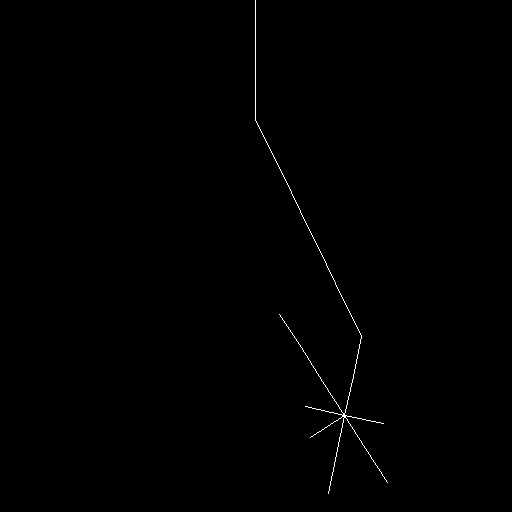

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 21), dtype=float64, numpy=
array([[1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2.,
        1., 0., 0., 1., 0.]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1000.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([32], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tenso

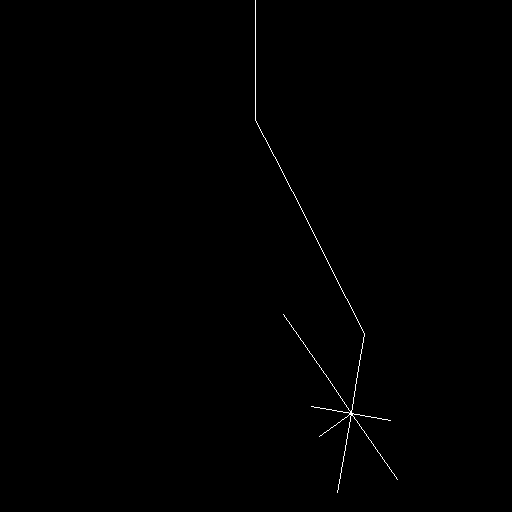

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 21), dtype=float64, numpy=
array([[1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2.,
        1., 0., 0., 1., 0.]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1000.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([32], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tenso

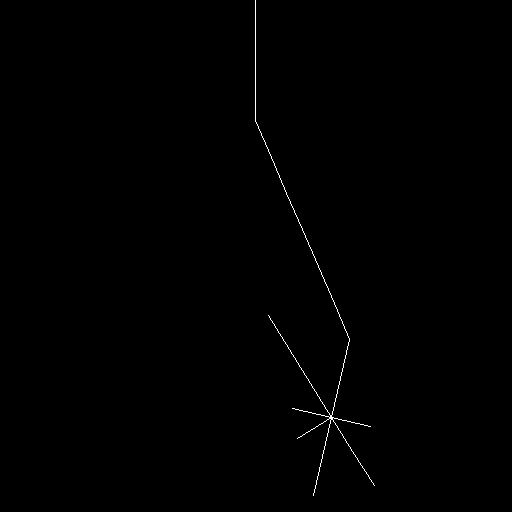

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 21), dtype=float64, numpy=
array([[1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2.,
        1., 0., 0., 1., 0.]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1000.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([32], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tenso

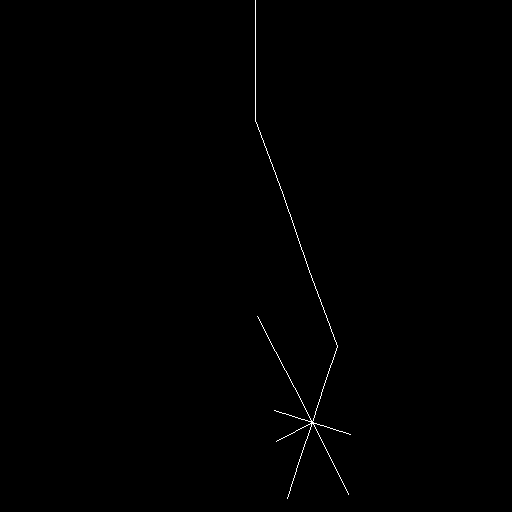

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 21), dtype=float64, numpy=
array([[1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2.,
        1., 0., 0., 1., 0.]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1000.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([32], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>, state=(), info=())
PolicyStep(action=<tf.Tenso

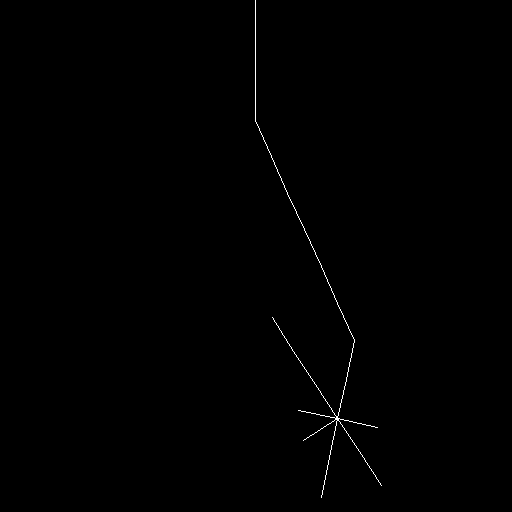

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 21), dtype=float64, numpy=
array([[1., 0., 1., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2.,
        1., 0., 0., 1., 0.]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1000.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})


In [14]:
create_policy_eval(agent.policy)

In [15]:
iterations = range(0, NUMBER_ITERATION + 1, EVAL_INTERVAL)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

NameError: ignored